In [1]:
#Author: Aaron Hertner
#Version: Python Base 3.8
#Purpose: To work more with different anomaly detection models on unstructured, labeled data

In [2]:
import warnings

#graphing and util
from matplotlib.cbook import mplDeprecation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sb
from collections import Counter
import time
from ipywidgets import interact, interactive
import itertools
from sklearn.metrics import confusion_matrix

#ML Libraries
from sklearn.model_selection import train_test_split

#ML Models
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore",category=mplDeprecation)

In [3]:
df_training = pd.read_csv('../_datasets/falling_persons_training.csv')
df_testing = pd.read_csv('../_datasets/falling_persons_testing.csv')

pd.options.display.max_columns = None
df_training.head()

,x,y,z,010-000-024-033,010-000-030-096,020-000-032-221,020-000-033-111,anomaly
0,18.495860,13.766527,14.362624,0.0,0.0,0.0,1.0,0.0
1,18.501072,13.827225,14.270268,0.0,0.0,1.0,0.0,0.0
2,18.405950,13.868976,14.094804,1.0,0.0,0.0,0.0,0.0
3,18.444572,13.910701,14.116078,0.0,1.0,0.0,0.0,0.0
4,18.418470,13.933917,14.320566,0.0,0.0,0.0,1.0,0.0


In [4]:
df_testing.head()

,x,y,z,010-000-024-033,010-000-030-096,020-000-032-221,020-000-033-111,anomaly
0,6.912997,11.518698,15.471855,0.0,0.0,0.0,1.0,0.0
1,6.936432,11.574586,15.446939,0.0,0.0,1.0,0.0,0.0
2,6.935274,11.571790,15.437505,1.0,0.0,0.0,0.0,0.0
3,6.886688,11.561593,15.704019,0.0,0.0,0.0,1.0,0.0
4,6.921823,11.597728,15.634435,0.0,0.0,1.0,0.0,0.0


In [5]:
df_training = df_training.drop(['010-000-024-033',
                                '010-000-030-096', 
                                '020-000-032-221', 
                                '020-000-033-111'], axis=1)
df_testing = df_testing.drop(['010-000-024-033',
                                '010-000-030-096', 
                                '020-000-032-221', 
                                '020-000-033-111'], axis=1)
df_training.head()

,x,y,z,anomaly
0,18.495860,13.766527,14.362624,0.0
1,18.501072,13.827225,14.270268,0.0
2,18.405950,13.868976,14.094804,0.0
3,18.444572,13.910701,14.116078,0.0
4,18.418470,13.933917,14.320566,0.0


In [6]:
df_testing.head()

,x,y,z,anomaly
0,6.912997,11.518698,15.471855,0.0
1,6.936432,11.574586,15.446939,0.0
2,6.935274,11.571790,15.437505,0.0
3,6.886688,11.561593,15.704019,0.0
4,6.921823,11.597728,15.634435,0.0


In [7]:
print(f'training set shape: {df_training.shape}')
print(f'testing set shape: {df_testing.shape}')

training set shape: (5805, 4)
testing set shape: (6623, 4)


In [8]:
df_training.isnull().sum()

x          0
y          0
z          0
anomaly    0
dtype: int64

In [9]:
df_testing.isnull().sum()

x          0
y          0
z          0
anomaly    0
dtype: int64

(343, 4) (6280, 4)


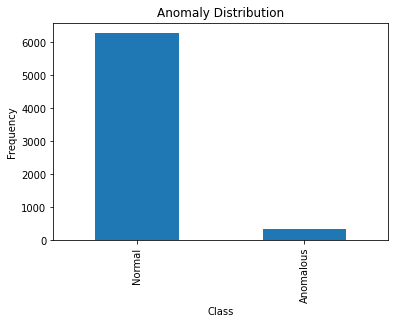

In [10]:
num_anoms = pd.value_counts(df_testing['anomaly'], sort = True)
num_anoms.plot(kind = 'bar')

plt.title("Anomaly Distribution")
plt.xticks(range(2), ["Normal", "Anomalous"])
plt.xlabel("Class")
plt.ylabel("Frequency")
fraud = df_testing[df_testing['anomaly'] == 1]
normal = df_testing[df_testing['anomaly'] == 0]
print(fraud.shape, normal.shape)

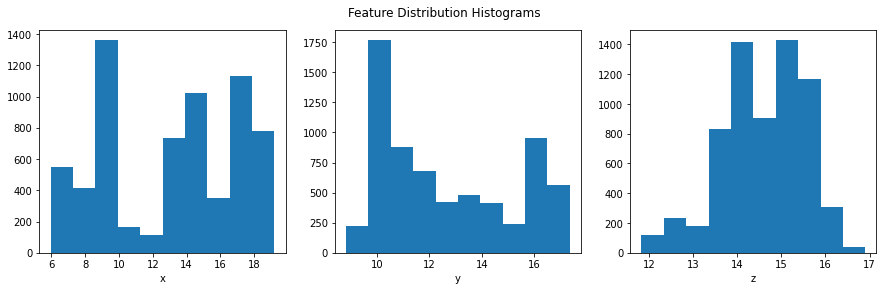

In [11]:
fig, axarr = plt.subplots(1,3, figsize=(15,4))

i = 0
for col in (df_testing.drop(['anomaly'], axis=1)).columns:
    axarr[i].hist(df_testing[col])
    axarr[i].set_xlabel(f'{col}')
    i += 1
    
plt.suptitle('Feature Distribution Histograms')
plt.subplots_adjust(top=0.9)

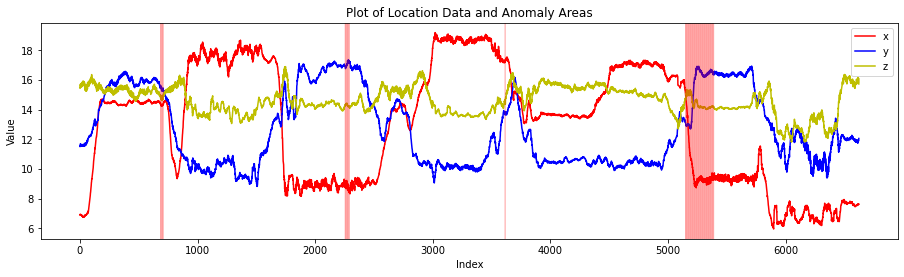

In [12]:
x_range = range(0, df_testing.shape[0])

fig = plt.figure(1, figsize=(17,10))
ax = fig.add_axes([0.15, 0.1, 0.7, 0.3])
ax.plot(x_range, df_testing['x'], label = 'x', color='r')
ax.plot(x_range, df_testing['y'], label = 'y', color='b')
ax.plot(x_range, df_testing['z'], label = 'z', color='y')
ax.set_title('Plot of Location Data and Anomaly Areas')
ax.set_xlabel('Index')
ax.set_ylabel('Value')

for i in range(df_training.shape[0]):
    if (df_training.loc[i, 'anomaly'] == 1):
        ax.axvline(i, linewidth=1, c = 'r', alpha = 0.05)

plt.legend()

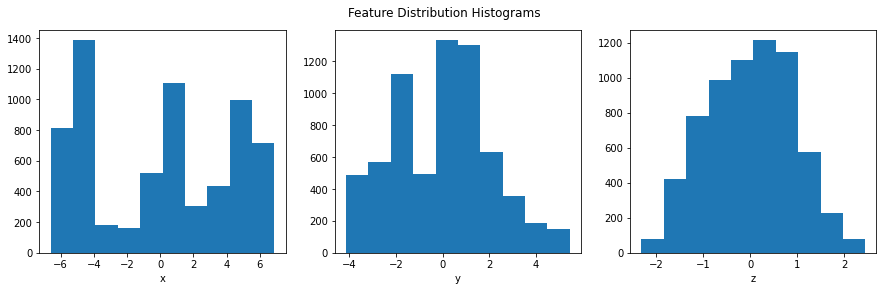

In [13]:
fig, axarr = plt.subplots(1,3, figsize=(15,4))

Y = df_testing['anomaly']
X = df_testing.drop(['anomaly'], axis=1)
pc = PCA()
X = pd.DataFrame(pc.fit_transform(X), columns = X.columns)

i = 0
for col in X.columns:
    axarr[i].hist(X[col])
    axarr[i].set_xlabel(f'{col}')
    i += 1
    
plt.suptitle('Feature Distribution Histograms')
plt.subplots_adjust(top=0.9)

In [14]:
def on_change(elevation, rotation):
    fig = plt.figure(1, figsize=(5,5))
    plt.clf()
    ax = fig.add_axes(Axes3D(fig, elev=elevation, azim=rotation))
    ax.scatter(X['x'], X['y'], X['z'], c=Y, cmap = plt.cm.get_cmap('plasma'))
    ax.set_title('3D Visualization of Person Location vs. Anomaly Areas')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return elevation, rotation

interactive_plot = interactive(on_change, elevation=(0, 180, 1), rotation=(0, 360 ,1))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(IntSlider(value=90, description='elevation', max=180), IntSlider(value=180, description=…


Model: IsoF ------------------
Anomalies: 5660/343
Normal: 963
Time(s): 0.27

Model: LOF ------------------
Anomalies: 5230/343
Normal: 1393
Time(s): 0.08

Model: OCSvm ------------------
Anomalies: 2666/343
Normal: 3957
Time(s): 2.70

Model: EEnv ------------------
Anomalies: 0/343
Normal: 6623
Time(s): 1.80

Model: RFC ------------------
Anomalies: 0/343
Normal: 6623
Time(s): 0.38


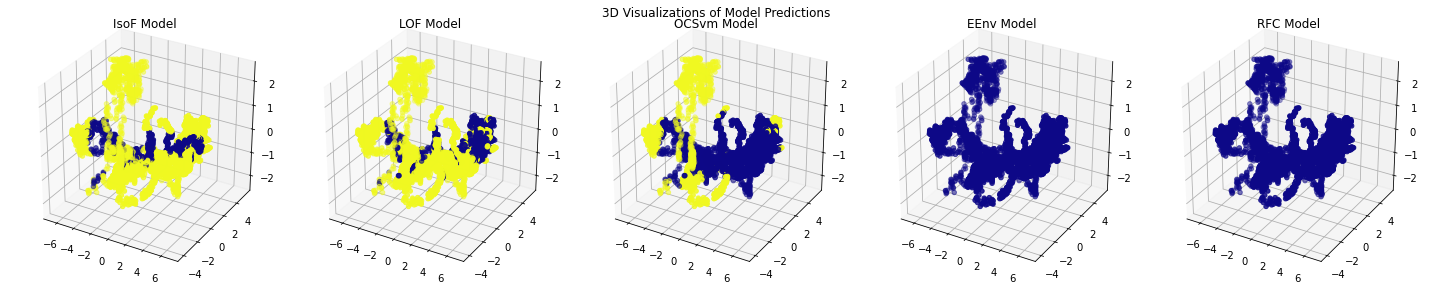

In [15]:
models = [('IsoF', IsolationForest()), 
          ('LOF', LocalOutlierFactor(novelty = True)),
          ('OCSvm', OneClassSVM()),
          ('EEnv', EllipticEnvelope()),
          ('RFC', RandomForestClassifier())]

x_train, y_train = df_training.loc[:,['x', 'y', 'z']], df_training['anomaly']
x_test, y_test = df_testing.loc[:,['x', 'y', 'z']], df_testing['anomaly']

x_train = pd.DataFrame(pc.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(pc.fit_transform(x_test), columns = x_test.columns)

fig = plt.figure(figsize=(20, 4))

for i in range(len(models)):
    start = time.time()
    
    if (models[i][0] == 'RFC'):
        models[i][1].fit(x_train, y_train)
    else:
        models[i][1].fit(x_train)
        
    y_pred = models[i][1].predict(x_test)
    end = time.time() - start
    
    #count anomalies
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    anoms = (y_pred == 1).sum()
    non_anoms = (y_pred == 0).sum()
    total_anoms = (y_test == 1).sum()
    
    print(f'\nModel: {models[i][0]} ------------------')
    print(f'Anomalies: {anoms}/{total_anoms}')
    print(f'Normal: {non_anoms}')
    print(f'Time(s): %.2f'%end)
        
    ax = fig.add_subplot(151 + i, projection='3d')
    ax.scatter(x_test['x'], x_test['y'], x_test['z'], c = y_pred, cmap = plt.cm.get_cmap('plasma'))
    ax.set_title(f'{models[i][0]} Model')

plt.suptitle('3D Visualizations of Model Predictions')
plt.tight_layout()

In [16]:
def comp_sets(real_set, gen_set):
    count = 0
    anoms = 0
    for i in range(len(real_set)):
        if (gen_set[i] == real_set[i]): count += 1
        if (gen_set[i] == real_set[i] == 1): anoms += 1
    return count, anoms

for i in range(len(models)):
    if (models[i][0] == 'RFC'):
        models[i][1].fit(x_train, y_train)
    else:
        models[i][1].fit(x_train)
    
    total_anoms_train = (y_train == 1).sum()
    total_anoms_test = (y_test == 1).sum()
    
    #get predictions for training data
    y_pred_train = models[i][1].predict(x_train)
    y_pred_train[y_pred_train == -1] = 0

    #accuracy for training data
    acc_train, train_anoms= comp_sets(y_train, y_pred_train)
    train_anoms_total = (y_pred_train == 1).sum()
    
    #get predictions for testing data
    y_pred_test = models[i][1].predict(x_test)
    y_pred_test[y_pred_test == -1] = 0
    
    #accuracy for testing data
    acc_test, test_anoms= comp_sets(y_test, y_pred_test)
    test_anoms_total = (y_pred_test == 1).sum()
    
    print(f'Model: {models[i][0]} ---------------------------------------|')
    print(f'Anomalies Detected in Training Set       : {train_anoms}/{total_anoms_train}')
    print(f'Total Anomalies Predicted in Training Set: {train_anoms_total}')
    print(f'Correct Predictions on Training Set      : {acc_train}/{len(y_train)} ({acc_train/len(y_train)})')
    print(f'Anomalies Detected in Testing Set        : {test_anoms}/{total_anoms_test}')
    print(f'Total Anomalies Predicted in Testing Set : {test_anoms_total}')
    print(f'Correct Predictions on Testing Set       : {acc_test}/{len(y_test)} ({acc_test/len(y_test)})\n')

Model: IsoF ---------------------------------------|
Anomalies Detected in Training Set       : 86/327
Total Anomalies Predicted in Training Set: 3795
Correct Predictions on Training Set      : 1855/5805 (0.3195521102497847)
Anomalies Detected in Testing Set        : 17/343
Total Anomalies Predicted in Testing Set : 1797
Correct Predictions on Testing Set       : 4517/6623 (0.6820172127434697)

Model: LOF ---------------------------------------|
Anomalies Detected in Training Set       : 322/327
Total Anomalies Predicted in Training Set: 5708
Correct Predictions on Training Set      : 414/5805 (0.07131782945736434)
Anomalies Detected in Testing Set        : 13/343
Total Anomalies Predicted in Testing Set : 1393
Correct Predictions on Testing Set       : 4913/6623 (0.7418088479540994)

Model: OCSvm ---------------------------------------|
Anomalies Detected in Training Set       : 77/327
Total Anomalies Predicted in Training Set: 2902
Correct Predictions on Training Set      : 2730/5805

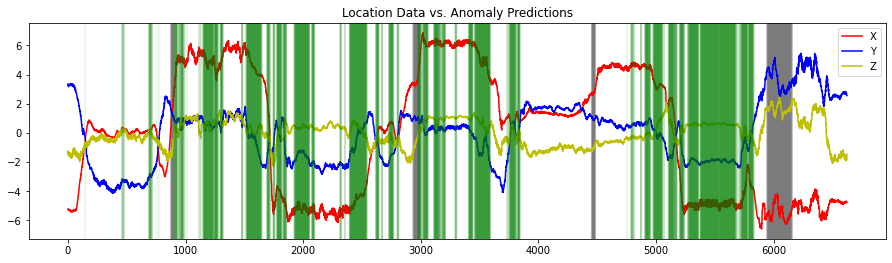

In [17]:
fig = plt.figure(1, figsize=(17,10))
ax = fig.add_axes([0.15, 0.1, 0.7, 0.3])

x_range = range(0, x_test.shape[0])

for i in x_range:
    if(y_test[i] == 1):
        ax.axvline(i, c='k', alpha = 0.05)

ax.plot(x_range, x_test['x'], color='r', label ='X')
ax.plot(x_range, x_test['y'], color='b', label ='Y')
ax.plot(x_range, x_test['z'], color='y', label ='Z')
        
iso = IsolationForest(n_estimators=100)
iso.fit(x_train, y_train)
y_pred = iso.predict(x_test)

for i in x_range:
    if(y_pred[i] == 1):
        ax.axvline(i, c='g', alpha=0.1)

ax.set_title('Location Data vs. Anomaly Predictions')
plt.legend()